In [6]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# Looking at the X, y
X.shape, y.shape, X[:10], y[:10]

((3629,),
 (3629,),
 array([11, 40, 70, 40, 18, 62, 34, 11, 40, 70]),
 array([40, 70, 40, 18, 62, 34, 11, 40, 70, 40]))

In [3]:
# Model or Network
import impl.layer as l

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.), 
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
        # Bi-directional
        self.model_l = []
        for _ in range(self.L):
            self.model_l.append(m)            

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dX_in = dX[:, self.H:]

        dh = dh_in1 + dh_in2
        dX = dX_in

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        # for X in X_train:
        for t in range(len(X_train)):
            X = X_train[t]
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def train_forward_l(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        # for X in X_train:
        for t in reversed(range(len(X_train))):
            X = X_train[t]
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model_l[layer])
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def train_backward_l(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model_l[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model_l[layer].items()})
        
        dXs = []
        for t in range(len(dys)):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads

#     def test(self, X_seed, h, size):
#         chars = [self.idx2char[X_seed]]
#         idx_list = list(range(self.vocab_size))
#         X = X_seed
        
#         h_init = h.copy()
#         h = []
#         for _ in range(self.L):
#             h.append(h_init.copy())

#         for _ in range(size):
#             # Right-directional
#             X_one_hot = np.zeros(self.D)
#             X_one_hot[X] = 1.
#             X = X_one_hot.reshape(1, -1)
#             for layer in range(self.L):
#                 y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
#                 X = y.copy()
#             # Left-directional
#             X_one_hot = np.zeros(self.D)
#             X_one_hot[X] = 1.
#             X = X_one_hot.reshape(1, -1)
#             for layer in range(self.L):
#                 y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
#                 X = y.copy()

#             prob = l.softmax(y)
#             idx = np.random.choice(idx_list, p=prob.ravel())
#             chars.append(self.idx2char[idx])
#             X = idx

#         return ''.join(chars)

In [4]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    #for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):

    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})

    M_l, R_l = [], []
    for layer in range(nn.L):
        M_l.append({k: np.zeros_like(v) for k, v in nn.model_l[layer].items()})
        R_l.append({k: np.zeros_like(v) for k, v in nn.model_l[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    eps = 1e-8
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            ys_l, caches_l = nn.train_forward_l(X_mini, state)
            ys += ys_l
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            _, grads_l = nn.train_backward_l(dys, caches_l)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)
                    
                for k in grads_l[layer].keys(): #key, value: items
                    M_l[layer][k] = l.exp_running_avg(M_l[layer][k], grads_l[layer][k], beta1)
                    R_l[layer][k] = l.exp_running_avg(R_l[layer][k], grads_l[layer][k]**2, beta2)

                    m_k_hat = M_l[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R_l[layer][k] / (1. - (beta2**(iter)))

                    nn.model_l[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
#             sample = nn.test(X_mini[0], state, 100)
#             print(sample)

    return nn

Iter-1 loss: 309.4318
Iter-2 loss: 287.5329
Iter-3 loss: 279.1090
Iter-4 loss: 273.4013
Iter-5 loss: 269.3631
Iter-6 loss: 266.3277
Iter-7 loss: 263.0172
Iter-8 loss: 256.7446
Iter-9 loss: 253.4718
Iter-10 loss: 248.6307
Iter-11 loss: 239.8086
Iter-12 loss: 233.8652
Iter-13 loss: 230.0072
Iter-14 loss: 225.8405
Iter-15 loss: 223.8493
Iter-16 loss: 220.4195
Iter-17 loss: 217.0637
Iter-18 loss: 217.4756
Iter-19 loss: 217.7577
Iter-20 loss: 215.0665
Iter-21 loss: 212.8956
Iter-22 loss: 211.5629
Iter-23 loss: 211.4263
Iter-24 loss: 211.0869
Iter-25 loss: 211.9673
Iter-26 loss: 211.0677
Iter-27 loss: 212.1399
Iter-28 loss: 211.6270
Iter-29 loss: 210.6031
Iter-30 loss: 208.4290
Iter-31 loss: 209.1585
Iter-32 loss: 207.7561
Iter-33 loss: 206.5024
Iter-34 loss: 205.8519
Iter-35 loss: 201.4642
Iter-36 loss: 200.1840
Iter-37 loss: 197.5507
Iter-38 loss: 197.1976
Iter-39 loss: 194.4914
Iter-40 loss: 189.8893
Iter-41 loss: 185.6482
Iter-42 loss: 181.7703
Iter-43 loss: 179.5737
Iter-44 loss: 180.24

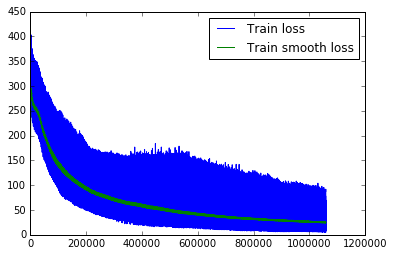

In [5]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 300 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()